In [1]:
import pandas as pd
from sklearn import datasets
from pandas_profiling import ProfileReport
import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import svm
import numpy as np
import sklearn

In [2]:
#----------------------------------
# Wczytanie danych
data = pd.read_csv(r'C:/Users/sebma/Documents/GitHub/Sebastian/Data/water_potability.csv')
df = pd.DataFrame(data=data)
profile = ProfileReport(df, title="Woda_raport", explorative=True)
profile.to_file("Woda_raport.pdf")

In [4]:
#--------------------------------
# Podstawowe informacje
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
# mamy braki danych
print("Ilość duplikatów: ", df.duplicated().sum())
# nie mamy duplikatów

Ilość duplikatów:  0


In [6]:
# jaki jest procentowy udzial pustych komorek
puste = df.isnull().sum().sort_values(ascending=False)
puste_procent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
braki = pd.concat([puste, puste_procent], axis=1, keys=['Łącznie', 'Procent'])
print(braki)

                 Łącznie    Procent
Sulfate              781  23.840049
ph                   491  14.987790
Trihalomethanes      162   4.945055
Hardness               0   0.000000
Solids                 0   0.000000
Chloramines            0   0.000000
Conductivity           0   0.000000
Organic_carbon         0   0.000000
Turbidity              0   0.000000
Potability             0   0.000000


In [8]:
# poki co je usuwamy
df.dropna(inplace=True)

In [10]:
#==============================Wykresy============================
@interact(kolumna=['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
                   'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'])
def wykresy(kolumna):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 5))
    axs[0].boxplot(df[kolumna])
    axs[0].set_xlabel("Boxplot zmiennej " + str(kolumna))
    axs[1].hist(df[kolumna])
    axs[1].set_xlabel("Histogram zmiennej " + str(kolumna))
    fig.suptitle("Zmienna " + str(kolumna).upper(), fontsize=16)
    return plt.show()

interactive(children=(Dropdown(description='kolumna', options=('ph', 'Hardness', 'Solids', 'Chloramines', 'Sul…

In [11]:
#  Statystyki
for col in df.columns:
    print(df[col].describe().apply(lambda x: format(x, 'f')).T, '\n','======================')

df.describe().round(2).T

count    2011.000000
mean        7.085990
std         1.573337
min         0.227499
25%         6.089723
50%         7.027297
75%         8.052969
max        14.000000
Name: ph, dtype: object 
count    2011.000000
mean      195.968072
std        32.635085
min        73.492234
25%       176.744938
50%       197.191839
75%       216.441070
max       317.338124
Name: Hardness, dtype: object 
count     2011.000000
mean     21917.441374
std       8642.239815
min        320.942611
25%      15615.665390
50%      20933.512750
75%      27182.587067
max      56488.672413
Name: Solids, dtype: object 
count    2011.000000
mean        7.134338
std         1.584820
min         1.390871
25%         6.138895
50%         7.143907
75%         8.109726
max        13.127000
Name: Chloramines, dtype: object 
count    2011.000000
mean      333.224672
std        41.205172
min       129.000000
25%       307.632511
50%       332.232177
75%       359.330555
max       481.030642
Name: Sulfate, dtype: object 
cou

,count,mean,std,min,25%,50%,75%,max
ph,2011.0,7.09,1.57,0.23,6.09,7.03,8.05,14.00
Hardness,2011.0,195.97,32.64,73.49,176.74,197.19,216.44,317.34
Solids,2011.0,21917.44,8642.24,320.94,15615.67,20933.51,27182.59,56488.67
Chloramines,2011.0,7.13,1.58,1.39,6.14,7.14,8.11,13.13
Sulfate,2011.0,333.22,41.21,129.00,307.63,332.23,359.33,481.03
Conductivity,2011.0,426.53,80.71,201.62,366.68,423.46,482.37,753.34
Organic_carbon,2011.0,14.36,3.32,2.20,12.12,14.32,16.68,27.01
Trihalomethanes,2011.0,66.40,16.08,8.58,55.95,66.54,77.29,124.00
Turbidity,2011.0,3.97,0.78,1.45,3.44,3.97,4.51,6.49
Potability,2011.0,0.40,0.49,0.00,0.00,0.00,1.00,1.00


In [12]:
# metodą IQR zamieniamy anomalie na wasy
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    up = Q3 + 1.5 * IQR
    print("Dla zmiennej ", col, "low =" ,low, " , up =", up)
    lowp = df[df[col]<low].shape[0]/df.shape[0]*100
    upp = df[df[col]>up].shape[0]/df.shape[0]*100
    print("Dla zmiennej ", col, "wartosci odstajacych z gory jest: ", upp,"%.")
    print("Wartosci odstajacych z dolu jest: ", lowp, "%",'\n')

Dla zmiennej  ph low = 3.144855430296987  , up = 10.997836820777836
Dla zmiennej  ph wartosci odstajacych z gory jest:  0.7956240676280457 %.
Wartosci odstajacych z dolu jest:  0.7458975634012929 % 

Dla zmiennej  Hardness low = 117.20073950080075  , up = 275.98526789178493
Dla zmiennej  Hardness wartosci odstajacych z gory jest:  1.093983092988563 %.
Wartosci odstajacych z dolu jest:  1.3426156141223273 % 

Dla zmiennej  Solids low = -1734.717124220855  , up = 44532.969581398465
Dla zmiennej  Solids wartosci odstajacych z gory jest:  1.39234211834908 %.
Wartosci odstajacych z dolu jest:  0.0 % 

Dla zmiennej  Chloramines low = 3.1826491396245804  , up = 11.065972268782946
Dla zmiennej  Chloramines wartosci odstajacych z gory jest:  1.04425658876181 %.
Wartosci odstajacych z dolu jest:  1.093983092988563 % 

Dla zmiennej  Sulfate low = 230.08544669106774  , up = 436.87761939587585
Dla zmiennej  Sulfate wartosci odstajacych z gory jest:  0.8453505718547987 %.
Wartosci odstajacych z dolu

In [13]:
for col in df.columns[:-1]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    up = Q3 + 1.5 * IQR
    df.loc[df[col] > up, col] = up
    df.loc[df[col] < low, col] = low

In [14]:
# Korelacja
korelacja_P = df.corr('pearson')
print(korelacja_P)

                       ph  Hardness    Solids  Chloramines   Sulfate  \
ph               1.000000  0.114481 -0.088930    -0.029831  0.011037   
Hardness         0.114481  1.000000 -0.050965    -0.022898 -0.105092   
Solids          -0.088930 -0.050965  1.000000    -0.052275 -0.153003   
Chloramines     -0.029831 -0.022898 -0.052275     1.000000  0.015692   
Sulfate          0.011037 -0.105092 -0.153003     0.015692  1.000000   
Conductivity     0.013825  0.011573 -0.006093    -0.029401 -0.014049   
Organic_carbon   0.025224  0.012793 -0.003798    -0.020838  0.022624   
Trihalomethanes  0.016636 -0.016693 -0.017519     0.012128 -0.022721   
Turbidity       -0.034174 -0.036554  0.021253     0.012040 -0.007596   
Potability       0.017873  0.001312  0.038995     0.019211 -0.012533   

                 Conductivity  Organic_carbon  Trihalomethanes  Turbidity  \
ph                   0.013825        0.025224         0.016636  -0.034174   
Hardness             0.011573        0.012793        

In [15]:
korelacja_S = df.corr('spearman')
print(korelacja_S)

                       ph  Hardness    Solids  Chloramines   Sulfate  \
ph               1.000000  0.138864 -0.079869    -0.038193  0.015850   
Hardness         0.138864  1.000000 -0.049729    -0.019885 -0.096206   
Solids          -0.079869 -0.049729  1.000000    -0.040835 -0.143259   
Chloramines     -0.038193 -0.019885 -0.040835     1.000000  0.024098   
Sulfate          0.015850 -0.096206 -0.143259     0.024098  1.000000   
Conductivity     0.008990  0.001242  0.005454    -0.021567 -0.020661   
Organic_carbon   0.026176  0.011449  0.004072    -0.020429  0.016831   
Trihalomethanes  0.018000 -0.021809 -0.022410     0.015523 -0.027469   
Turbidity       -0.046441 -0.028602  0.024041     0.001658 -0.012564   
Potability       0.014048  0.008643  0.034983     0.021662 -0.008997   

                 Conductivity  Organic_carbon  Trihalomethanes  Turbidity  \
ph                   0.008990        0.026176         0.018000  -0.046441   
Hardness             0.001242        0.011449        

In [16]:
#tworzymy macierz trójkątną i wyświetlamy wspóczynnik korelacji większy od 0.5
korelacja_P_tr = korelacja_P.where(np.triu(np.ones(korelacja_P.shape, dtype=np.bool), k=1)).stack().sort_values()
korelacja_P_tr[abs(korelacja_P_tr)>0.1]

<ipython-input-16-5f87e9b70c42>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  korelacja_P_tr = korelacja_P.where(np.triu(np.ones(korelacja_P.shape, dtype=np.bool), k=1)).stack().sort_values()


Solids    Sulfate    -0.153003
Hardness  Sulfate    -0.105092
ph        Hardness    0.114481
dtype: float64

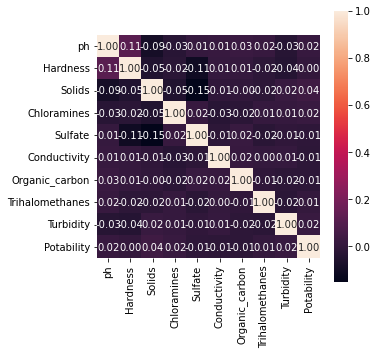

In [18]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(korelacja_P, square=True, annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

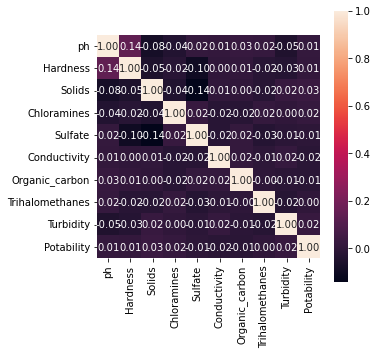

In [19]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(korelacja_S, square=True, annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [38]:
df.describe()['ph']['mean']

7.086981314622033

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,2011.0,7.086981,1.533698,3.144855,6.089723,7.027297,8.052969,10.997837
Hardness,2011.0,196.055749,31.899336,117.200740,176.744938,197.191839,216.441070,275.985268
Solids,2011.0,21868.637825,8493.143737,320.942611,15615.665390,20933.512750,27182.587067,44532.969581
Chloramines,2011.0,7.131934,1.545770,3.182649,6.138895,7.143907,8.109726,11.065972
Sulfate,2011.0,333.347354,40.067552,230.085447,307.632511,332.232177,359.330555,436.877619
Conductivity,2011.0,426.418770,80.362231,201.619737,366.680307,423.455906,482.373169,655.912460
Organic_carbon,2011.0,14.358055,3.307772,5.285688,12.124105,14.322019,16.683049,23.521466
Trihalomethanes,2011.0,66.407119,15.900017,23.943772,55.952664,66.542198,77.291925,109.300818
Turbidity,2011.0,3.969582,0.776245,1.836026,3.442915,3.968177,4.514175,6.121065
Potability,2011.0,0.403282,0.490678,0.000000,0.000000,0.000000,1.000000,1.000000


In [20]:
# Podział zbioru
X = df.drop(labels=['Potability'], axis=1)
Y = df.iloc[:, 9]

In [39]:
clf = svm.SVC()

clf.fit(X, Y)

clf.predict([[df.describe()['ph']['mean'], df.describe()['Hardness']['mean'], df.describe()['Solids']['mean'],
              df.describe()['Chloramines']['mean'], df.describe()['Sulfate']['mean'], df.describe()['Conductivity']['mean'],
              df.describe()['Organic_carbon']['mean'], df.describe()['Trihalomethanes']['mean'], df.describe()['Turbidity']['mean']]])

array([0], dtype=int64)

In [22]:
X_ucz, X_test, Y_ucz, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=12345)
print(X_ucz.shape)
print(X_test.shape)
print(Y_ucz.shape)
print(Y_test.shape)

(1608, 9)
(403, 9)
(1608,)
(403,)


In [ ]:
# zbalansowac dane, uzyc metryk sprawdzajacych model, lepiej ogarnac nulle i wartosci odstajace
# regresja lasso ridge, optuna, standaryzacja

In [40]:
from sklearn import preprocessing
import numpy as np